# Tensorflow: Basic Text Classification - Multiclass Label
* Reference: https://www.tensorflow.org/tutorials/keras/text_classification#exercise_multi-class_classification_on_stack_overflow_questions

## Setup

In [265]:
import io, os, re, shutil
import string
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 300

import tensorflow as tf
from tensorflow.keras import layers, losses

%load_ext tensorboard

## Download the Stack Overflow Dataset

In [5]:
# Download the dataset to be used to the location CACHE_DIR/DATASET_SUBDIR
CACHE_DIR = '.\\data'
DATASET_URL = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
DATASET_SUBDIR = 'stackoverflowdb'
DATASET_ZIPFILE = 'stack_overflow_16k.tar.gz'

In [3]:
dataset = tf.keras.utils.get_file(
            DATASET_ZIPFILE, DATASET_URL,
            untar=True, cache_dir=CACHE_DIR, cache_subdir=DATASET_SUBDIR)

6062080/6053168 [==============================] - 0s 0us/step


In [7]:
dataset_dir = os.path.join( CACHE_DIR, DATASET_SUBDIR )
print(dataset_dir)
os.listdir(dataset_dir)

.\data\stackoverflowdb


['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [9]:
# Get the directory name of the training data
train_dir = os.path.join(dataset_dir, 'train')
print(train_dir)
os.listdir(train_dir)

.\data\stackoverflowdb\train


['csharp', 'java', 'javascript', 'python']

In [10]:
test_dir = os.path.join(dataset_dir, 'test')
print(test_dir)
os.listdir(test_dir)

.\data\stackoverflowdb\test


['csharp', 'java', 'javascript', 'python']

In [7]:
# # Remove directory containing unsupervised examples
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [199]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
            train_dir, batch_size=batch_size,
            validation_split=0.2, subset='training',
            seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            train_dir, batch_size=batch_size,
            validation_split=0.2, subset='validation',
            seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [200]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            test_dir, batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [201]:
for i,c in enumerate(raw_train_ds.class_names):
    print(f"Label: {i} => Class: {c}")

Label: 0 => Class: csharp
Label: 1 => Class: java
Label: 2 => Class: javascript
Label: 3 => Class: python


In [202]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(1):
    print(f"Label: {label_batch.numpy()[i]} ({raw_train_ds.class_names[label_batch.numpy()[i]]})"
          f" => Post: {text_batch.numpy()[i]}")

Label: 1 (java) => Post: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses t

## Text Preprocessing

In [203]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_punct = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return stripped_punct

In [373]:
# Vocabulary size (features) and number of words in a sequence (review).
# max_features = 10000
# sequence_length = 250
max_features = 15000
sequence_length = 350

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = layers.TextVectorization(
                    standardize=custom_standardization,
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=sequence_length)

In [374]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [375]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [376]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"list<t>contains method as extension method not working? i want to write an extension method like the contains method of the list class for the list class that takes an null able object. .my extension method is :..public static class customlist.    {.        public static bool contains&lt;t&gt;(this list&lt;t&gt; lst, nullable&lt;t&gt; obj) where t : struct.        {.            bool bcontains = false;.            if (obj == null).            {.                bcontains = false;.            }.            else.            {.                t obj1 = (t)obj.value;.                bcontains = lst.contains(obj1);.            }..            return bcontains;.        }.}...my  linq code which calls the extension method is given below:..var lstjobactivity = (from objactivity in context.vw_job_activity.                                  where jobassignid.contains(objactivity.assign_id) &amp;&amp; objactivity.activity_type == ""jbintv"".                                  select 

In [377]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  saw
 313 --->  source
Vocabulary size: 15000


In [378]:
# Create vectorized training, validation, and test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [379]:
[ x for x in train_ds.take(1).as_numpy_iterator() ]
# print(dir(train_ds))

[(array([[  987,    38,  6673, ...,     0,     0,     0],
         [   24,     4,   693, ...,     0,     0,     0],
         [ 2932,  1096,   645, ...,     0,     0,     0],
         ...,
         [10948,  4095,   223, ...,     0,     0,     0],
         [    1,    74,   254, ...,     0,     0,     0],
         [    1,   231,  1429, ...,     0,     0,     0]], dtype=int64),
  array([0, 1, 0, 2, 1, 1, 1, 3, 0, 1, 1, 0, 3, 2, 1, 2, 0, 0, 3, 0, 1, 2,
         1, 0, 1, 1, 0, 3, 1, 2, 0, 0]))]

## Configure the Dataset for Performance

In [380]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a Classification Model

In [381]:
embedding_dim = 32
model = tf.keras.Sequential( [
    layers.Embedding( max_features+1, embedding_dim ),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
    ])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          480032    
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d_10  (None, 32)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 132       
Total params: 480,164
Trainable params: 480,164
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the Model

In [382]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
LOGS_ROOTDIR = os.path.join('.', 'logs')
this_run_log_dir = os.path.join( LOGS_ROOTDIR, "fit_" + dt.datetime.now().strftime("%Y%m%d-%H%M%S") )
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=this_run_log_dir, histogram_freq=1)
print(f"Prepared log dir: {this_run_log_dir}")

# Stop epochs if validation loss is increasing
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Prepared log dir: .\logs\fit_20211119-135006


In [383]:
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [384]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback, earlystopping_callback]
    )

Epoch 1/100
200/200 [==============================] - 8s 36ms/step - loss: 1.3766 - accuracy: 0.3369 - val_loss: 1.3636 - val_accuracy: 0.4675
Epoch 2/100
200/200 [==============================] - 3s 17ms/step - loss: 1.3425 - accuracy: 0.4719 - val_loss: 1.3182 - val_accuracy: 0.5675
Epoch 3/100
200/200 [==============================] - 3s 17ms/step - loss: 1.2817 - accuracy: 0.5544 - val_loss: 1.2490 - val_accuracy: 0.6144
Epoch 4/100
200/200 [==============================] - 4s 18ms/step - loss: 1.2009 - accuracy: 0.6072 - val_loss: 1.1675 - val_accuracy: 0.6631
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 1.1121 - accuracy: 0.6630 - val_loss: 1.0850 - val_accuracy: 0.6956
Epoch 6/100
200/200 [==============================] - 3s 17ms/step - loss: 1.0288 - accuracy: 0.7017 - val_loss: 1.0083 - val_accuracy: 0.7212
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 0.9492 - accuracy: 0.7391 - val_loss: 0.9395 - val_accuracy:

## Evaluate the Model

250/250 [==============================] - 3s 13ms/step - loss: 0.5350 - accuracy: 0.8035
Loss:  0.5350119471549988
Accuracy:  0.8034999966621399
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


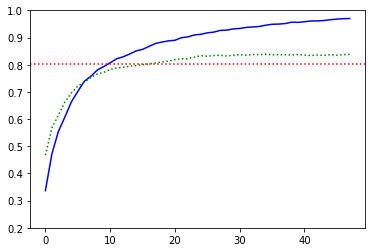

In [385]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
print( history_dict.keys() )

plt.plot( 'accuracy', 'b-', data=history.history )
plt.plot( 'val_accuracy', 'g:', data=history.history )
# plt.plot( [accuracy]*len(history.history['binary_accuracy']), 'r--', data=history.history )
y_axis_min_val = max( 0, round(min(accuracy, min(history.history['val_accuracy']), min(history.history['accuracy']) )-0.1, 1) )
_ = plt.ylim( y_axis_min_val, 1.0)
plt.axhline( accuracy, color='r', linestyle=':')

In [386]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23932), started 1 day, 22:48:26 ago. (Use '!kill 23932' to kill it.)

## Export the Model

In [387]:
# Wrap the trained model to permit it to be used directly in input strings (vs. vectors)
# and then apply an activation layer to yield a floating result between 0 and 1
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Softmax()
    ])

export_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, 350)               0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 4)                 480164    
_________________________________________________________________
softmax_6 (Softmax)          (None, 4)                 0         
Total params: 480,164
Trainable params: 480,164
Non-trainable params: 0
_________________________________________________________________


In [388]:
export_model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [389]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 13ms/step - loss: 0.5350 - accuracy: 0.8035
0.8034999966621399


In [390]:
# Some test examples
n_examples = 16
examples_np = [ x for x in raw_test_ds.take(n_examples).as_numpy_iterator() ]
examples = [ x[0][0].decode() for x in examples_np ]
true_labels = [ x[1][0] for x in examples_np ]
true_classes = [ raw_train_ds.class_names[label] for label in true_labels ]

preds = export_model.predict(examples)
pred_labels = list(np.argmax(preds, axis=1))
pred_classes = [ raw_train_ds.class_names[label] for label in pred_labels ]
r_df = pd.concat([
        pd.DataFrame( {'Post': examples,
                       'True Label': true_labels, 'True Class': true_classes,
                       'Predicted Label': pred_labels, 'Predicted Class': pred_classes
                      }),
        pd.DataFrame( preds, columns=['c0 (csharp)', 'c1 (java)', 'c2 (javascript)', 'c3 (python)'] ),
        pd.DataFrame( np.max(preds, axis=1) / np.mean(preds, axis=1), columns=['max/mean'] )
        ], axis=1 )
r_df['Prediction Correct'] = r_df['Predicted Label'] == r_df['True Label']
r_df = r_df[['Post', 'True Label', 'True Class', 'Predicted Label',
       'Predicted Class', 'c0 (csharp)', 'c1 (java)', 'c2 (javascript)',
       'c3 (python)', 'max/mean', 'Prediction Correct']]
r_df.sort_values(by=['Prediction Correct', 'max/mean'], ascending=[False, False], inplace=True)
r_df

,Post,True Label,True Class,Predicted Label,Predicted Class,c0 (csharp),c1 (java),c2 (javascript),c3 (python),max/mean,Prediction Correct
2,"""add event listener for a div whenever it appe...",2,javascript,2,javascript,0.000,0.000,1.000,0.000,4.000,True
15,"""just some thing i am working on that is broke...",1,java,1,java,0.000,1.000,0.000,0.000,4.000,True
14,"""the sum of two linked lists a class nat repre...",1,java,1,java,0.001,0.999,0.000,0.000,3.996,True
6,"""modulenotfounderror: no module named 'test2' ...",3,python,3,python,0.001,0.001,0.001,0.997,3.987,True
11,"""blank 'select' on change go to anchor (anchor...",2,javascript,2,javascript,0.006,0.000,0.994,0.000,3.976,True
12,"""blank removing item from listbox then it will...",0,csharp,0,csharp,0.992,0.005,0.003,0.000,3.966,True
13,"""how can i recode this nested for loop countin...",1,java,1,java,0.025,0.974,0.000,0.001,3.895,True
10,"""add/remove active class blank there is my sol...",2,javascript,2,javascript,0.005,0.006,0.971,0.018,3.886,True
4,"""error on adjusting jpeg quality: value cannot...",0,csharp,0,csharp,0.950,0.047,0.001,0.002,3.800,True
7,"""how to remove a pair in hashtable knowing the...",0,csharp,0,csharp,0.939,0.041,0.001,0.019,3.757,True


## Retrieve the Trained Word Embeddings and Save them to Disk

In [28]:
# weights = model.get_layer('embedding').get_weights()[0]
# vocab = vectorize_layer.get_vocabulary()

# with io.open('./data/vectors.tsv', 'w', encoding='utf-8') as out_v:
#     with io.open('./data/metadata.tsv', 'w', encoding='utf-8') as out_m:
#         for index, word in enumerate(vocab):
#             if index == 0:
#                 continue    # skip 0, it's padding
                
#             vec = weights[index]
#             out_v.write( '\t'.join( [ str(x) for x in vec ]) + '\n' )
#             out_m.write( word + '\n' )


## Visualize the Embeddings
* Tensorflow Embedding Projector: http://projector.tensorflow.org/
* Click on "Load data".
* Upload the two files you created above: vecs.tsv and meta.tsv.